# CE-40717: Machine Learning

## HW4-MultiLayer Perceptron (MLP)

The following lines of code will load the [MNIST](http://yann.lecun.com/exdb/mnist/) data and turn them
into numpy arrays, you can print their shape if you like.
You can also transform the data as you wish, including seperating
the training data for cross validation.

If you have the data (on google drive or locally) change the root
address accordingly, if you don't, set download=True but you might encounter
some problems downloading the data.

In [ ]:
'''
Ali Rabiee 99210389
'''

In [ ]:
import torchvision.datasets as ds
import numpy as np

data_train = np.array(ds.MNIST(root="./data", train=True, download=True).data)
target_train = np.array(ds.MNIST(root="./data", train=True, download=True).targets)
data_test = np.array(ds.MNIST(root="./data", train=False, download=True).data)
target_test = np.array(ds.MNIST(root="./data", train=False, download=True).targets)

#### Transform the data! ####
# Normalize Data
data_train, data_test = data_train/255, data_test/255
# Vectorize Data
data_train = data_train.reshape(data_train.shape[0], -1)
data_test = data_test.reshape(data_test.shape[0], -1)
# Check Dimensions 
print(data_train.shape)
print(data_test.shape)

(60000, 784)
(10000, 784)


### Part1:
Complete the functions of the MLP class to create
a MultiLayer Perceptron

In [ ]:
def ReLU(x, der=False):
    return (x>0)*1 if der else np.maximum(x, 0) 

def softmax(x, der=False):
    exps = np.exp(x - x.max())
    sigma = np.sum(exps, axis=0)
    return exps / sigma * (1 - exps / sigma) if der else exps / sigma

def one_hot(x):
    out = np.zeros((x.size, x.max() + 1))
    out[np.arange(x.size), x] = 1
    return out.T

def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [ ]:
class MLP:
    def __init__(self, in_dimensions, hidden_dimensions, out_dimensions):
      
        self.w1 = np.random.normal(size=(in_dimensions, hidden_dimensions)) / in_dimensions
        self.b1 = np.random.normal(size=(1,hidden_dimensions)) / in_dimensions
        self.w2 = np.random.normal(size=(hidden_dimensions,out_dimensions)) / in_dimensions
        self.b2 = np.random.normal(size=(1,out_dimensions)) / in_dimensions

    def forward(self, x):
        # perform a forward pass of the network and return the result
        # remember to retain the value of each node (i.e. self.h1_forward)
        # in order to use in backpropagation
        # Use whatever activation function you wish for the first layer
        # and softmax activation for the output layer
        self.input = x.T 
        self.z1_forward = (self.w1.T @ self.input) + self.b1.T
        self.h1_forward = ReLU(self.z1_forward)
        self.z2_forward = (self.w2.T @ self.h1_forward) + self.b2.T
        self.h2_forward = softmax(self.z2_forward)
        
    def backward(self, loss, y):
        # perform backpropagation on the loss value and compute the gradient 
        # w.r.t. every element of the network and retain them (i.e. self.w1_backward)
        self.delta_wrt_z2 = self.h2_forward - one_hot(y)
        self.delta_wrt_w2 = 1 / y.size * self.delta_wrt_z2 @ self.h1_forward.T
        self.delta_wrt_b2 = 1 / y.size * np.sum(self.delta_wrt_z2)
        self.delta_wrt_z1 = (self.w2 @ self.delta_wrt_z2) * ReLU(self.z1_forward, der=True)
        self.delta_wrt_w1 = 1 / y.size * self.delta_wrt_z1 @ self.input.T
        self.delta_wrt_b1 = 1 / y.size * np.sum(self.delta_wrt_z1)
      
    def step(self, lr, lam):
        # simply update all the weights using the gradinets computed in backward
        # and the given learning rate with SGD
        # don't forget to use regularization
        self.w1 = self.w1 - lr * (self.delta_wrt_w1.T + lam * self.w1)
        self.b1 = self.b1 - lr * (self.delta_wrt_b1.T + lam * self.b1)
        self.w2 = self.w2 - lr * (self.delta_wrt_w2.T + lam * self.w2)
        self.b2 = self.b2 - lr * (self.delta_wrt_b2.T + lam * self.b2)

### Part2:
Make instances of your network and train them **using l2 regularization and choose the lambda using k-fold cross validation
(set the candidate lambda as you wish)**.

You may choose the hyperparameters (i.e. num of epochs, learning rate etc.)
as you wish. 

Then train a final model on all the training data with the chosen lambda.


In [ ]:
n_epochs = 50 # number of epochs
lr = 0.6 # learning rate
k = 20 # number of folds
in_dim = 784 # MNIST has 28*28 images
hidden_dim = 20 # number of hidden dimensions for the hidden layer
out_dim =  10 # MNIST has 10 classes
fold_len = int(data_train.shape[0]/k)
lambdas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5] 
best_lambda = lambdas[-1]
best_acc = 0

for l in lambdas:
    #model = MLP(in_dim, hidden_dim, out_dim)
    acc = 0 # accuracy for current lambda
    loss = 0 # loss for current lambda
    acc_history = []
    loss_history = []
    for j in range(k):
        model = MLP(in_dim, hidden_dim, out_dim)
        fold_train_set = np.concatenate(
            (data_train[:j * fold_len], data_train[(j+1) * fold_len:])) 
        fold_train_target = np.concatenate(
            (target_train[:j * fold_len], target_train[(j+1) * fold_len:])) 
        val_set = data_train[j * fold_len:(j+1) * fold_len] 
        val_target = target_train[j * fold_len:(j+1) * fold_len] 

        for i in range(n_epochs):
            # train the model on the data with the current lambda
            # train the model on the data with the curent lambda
            model.forward(fold_train_set)
            pred = np.argmax(model.h2_forward, 0)
            loss = cross_entropy(pred, fold_train_target)
            model.backward(loss, fold_train_target)
            model.step(lr, l)
        # test the model on the current validation data
        model.forward(val_set)
        pred = np.argmax(model.h2_forward, 0)
        acc_of_fold = np.sum(pred == val_target) / val_target.size
        loss_of_fold = cross_entropy(pred, val_target)
        acc_history.append(acc_of_fold)
        loss_history.append(loss_of_fold)

    acc = np.mean(acc_history)
    loss = np.mean(loss_history)

    print("Lambda:", l)
    print("Loss: %.4f Accuracy: %.4f" % (loss, acc))
    print()
    if acc > best_acc:
        best_acc = acc
        best_lambda = l

print("Best lambda is",best_lambda, "with %.4f accuracy" % best_acc)

Lambda: 0.1
Loss: 1.2475 Accuracy: 0.7181

Lambda: 0.01
Loss: 1.3818 Accuracy: 0.7797

Lambda: 0.001
Loss: 1.6826 Accuracy: 0.7834

Lambda: 0.0001
Loss: 1.2319 Accuracy: 0.7905

Lambda: 1e-05
Loss: 1.3977 Accuracy: 0.7826

Best lambda is 0.0001 with 0.7905 accuracy


### Part3:
Train a final model using the best lambda on all the training data

In [ ]:
n_epochs = 100 # number of epochs
lr = 0.25 # learning rate
model = MLP(in_dim, hidden_dim, out_dim)# new model
loss_history = []
acc_history = []
for i in range(n_epochs):
    #### training code here ####
    model.forward(data_train)
    pred = np.argmax(model.h2_forward, 0)
    acc = np.sum(pred == target_train) / target_train.size
    acc_history.append(acc)
    loss = cross_entropy(pred, target_train)
    loss_history.append(loss)
    model.backward(loss, target_train)
    model.step(lr, best_lambda)
    if (i+1)%10 == 0 :
      print(f"epoch: {i+1}\tLoss: {loss:3f}  Accuracy: {acc:3f}")

epoch: 10	Loss: 0.005526  Accuracy: 0.112633
epoch: 20	Loss: 67.142215  Accuracy: 0.154500
epoch: 30	Loss: 84.803457  Accuracy: 0.190900
epoch: 40	Loss: 69.611273  Accuracy: 0.229350
epoch: 50	Loss: 21.343244  Accuracy: 0.416767
epoch: 60	Loss: 4.386904  Accuracy: 0.628967
epoch: 70	Loss: 1.884690  Accuracy: 0.696133
epoch: 80	Loss: 1.277182  Accuracy: 0.743817
epoch: 90	Loss: 1.043021  Accuracy: 0.780700
epoch: 100	Loss: 0.916960  Accuracy: 0.808467


### Part4:

Plot the training loss value and accuracy (mean over all batches each epoch if you're using mini-batches) over epochs
for the final model that is trained on all the training data

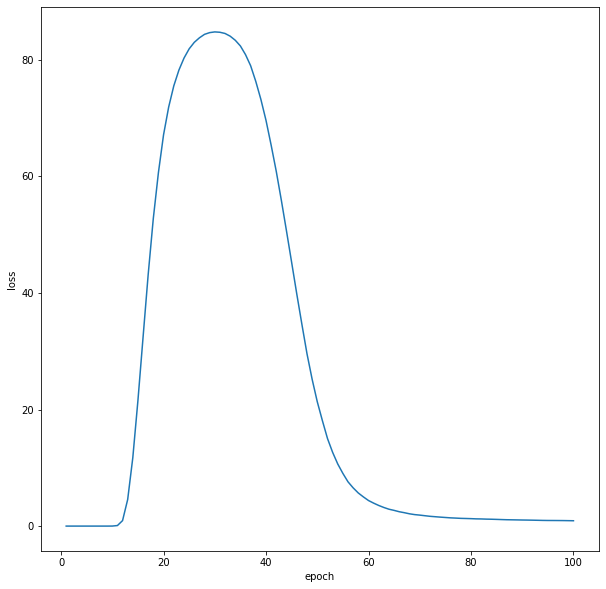

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, n_epochs+1)
plt.figure(figsize=(10,10))
plt.plot(epochs, loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Use your network on the test set and report the accuracy, you must get at least 70% accuracy on the test set.

In [ ]:
model.forward(data_test)
pred = np.argmax(model.h2_forward, 0)
acc = (np.sum(pred == target_test) / target_test.size)*100
print(f"Accuracy: {acc:3f} %")

Accuracy: 81.730000 %


Below you can add code cells and improve on the network structure as you see fit (it still must be an MLP), train and test your network and explain why it works better.


In [ ]:
class MLP_improve:
    def __init__(self, in_dimensions, hidden_dimension1, hidden_dimension2, out_dimensions):
      # Here I use better initialization for weights 
        self.w1 = np.random.rand(in_dimensions, hidden_dimension1) - 0.5
        self.b1 = np.random.rand(1, hidden_dimension1) - 0.5
        self.w2 = np.random.rand(hidden_dimension1, hidden_dimension2) - 0.5
        self.b2 = np.random.rand(1, hidden_dimension2) - 0.5
        self.w3 = np.random.rand(hidden_dimension2, out_dimensions) - 0.5
        self.b3 = np.random.rand(1, out_dimensions) - 0.5

    def forward(self, x):
      
        self.input = x.T 
        self.z1_forward = (self.w1.T @ self.input) + self.b1.T
        self.h1_forward = ReLU(self.z1_forward)
        self.z2_forward = (self.w2.T @ self.h1_forward) + self.b2.T
        self.h2_forward = ReLU(self.z2_forward)
        self.z3_forward = (self.w3.T @ self.h2_forward) + self.b3.T
        self.h3_forward = softmax(self.z3_forward)
        
    def backward(self, loss, y):
        self.delta_wrt_z3 = self.h3_forward - one_hot(y)
        self.delta_wrt_w3 = 1 / y.size * self.delta_wrt_z3 @ self.h2_forward.T
        self.delta_wrt_b3 = 1 / y.size * np.sum(self.delta_wrt_z3)
        self.delta_wrt_z2 = (self.w3 @ self.delta_wrt_z3) * ReLU(self.z2_forward, der=True)
        self.delta_wrt_w2 = 1 / y.size * self.delta_wrt_z2 @ self.h1_forward.T
        self.delta_wrt_b2 = 1 / y.size * np.sum(self.delta_wrt_z2)
        self.delta_wrt_z1 = (self.w2 @ self.delta_wrt_z2) * ReLU(self.z1_forward, der=True)
        self.delta_wrt_w1 = 1 / y.size * self.delta_wrt_z1 @ self.input.T
        self.delta_wrt_b1 = 1 / y.size * np.sum(self.delta_wrt_z1)
      
    def step(self, lr, lam):
        
        self.w1 = self.w1 - lr * (self.delta_wrt_w1.T + lam * self.w1)
        self.b1 = self.b1 - lr * (self.delta_wrt_b1.T + lam * self.b1)
        self.w2 = self.w2 - lr * (self.delta_wrt_w2.T + lam * self.w2)
        self.b2 = self.b2 - lr * (self.delta_wrt_b2.T + lam * self.b2)
        self.w3 = self.w3 - lr * (self.delta_wrt_w3.T + lam * self.w3)
        self.b3 = self.b3 - lr * (self.delta_wrt_b3.T + lam * self.b3)

In [ ]:
# Train Model
n_epochs = 200 
lr = 0.75 
in_dim = 784
hidden_dim1 = 32
hidden_dim2 = 16
out_dim =  10 
best_lambda = lambdas[-1]
model = MLP_improve(in_dim, hidden_dim1, hidden_dim2, out_dim)
loss_history = []
acc_history = []
for i in range(n_epochs):
    #### training code here ####
    model.forward(data_train)
    pred = np.argmax(model.h3_forward, 0)
    acc = np.sum(pred == target_train) / target_train.size
    acc_history.append(acc)
    loss = cross_entropy(pred, target_train)
    loss_history.append(loss)
    model.backward(loss, target_train)
    model.step(lr, best_lambda)
    if (i+1)%10 == 0:
      print(f"epoch: {i+1}\tLoss: {loss:3f}  Accuracy: {acc:3f}")

epoch: 10	Loss: 9.562290  Accuracy: 0.428450
epoch: 20	Loss: 2.780928  Accuracy: 0.519650
epoch: 30	Loss: 0.196862  Accuracy: 0.524233
epoch: 40	Loss: 1.529994  Accuracy: 0.779533
epoch: 50	Loss: 1.416712  Accuracy: 0.789100
epoch: 60	Loss: 0.847195  Accuracy: 0.816483
epoch: 70	Loss: 0.623395  Accuracy: 0.823517
epoch: 80	Loss: 0.637900  Accuracy: 0.855650
epoch: 90	Loss: 0.578151  Accuracy: 0.856017
epoch: 100	Loss: 0.557429  Accuracy: 0.864367
epoch: 110	Loss: 0.616833  Accuracy: 0.883100
epoch: 120	Loss: 0.578842  Accuracy: 0.886883
epoch: 130	Loss: 0.509422  Accuracy: 0.880733
epoch: 140	Loss: 0.510113  Accuracy: 0.895167
epoch: 150	Loss: 0.482138  Accuracy: 0.898800
epoch: 160	Loss: 0.490082  Accuracy: 0.895567
epoch: 170	Loss: 0.549140  Accuracy: 0.906633
epoch: 180	Loss: 0.523237  Accuracy: 0.911333
epoch: 190	Loss: 0.529454  Accuracy: 0.910417
epoch: 200	Loss: 0.501824  Accuracy: 0.911533


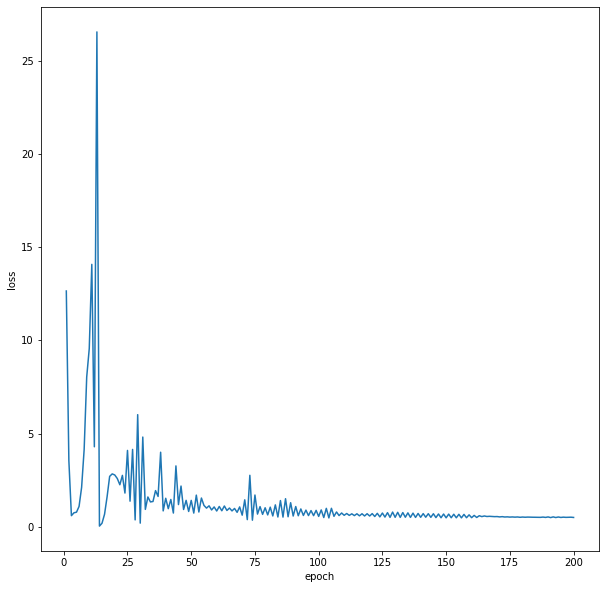

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, n_epochs+1)
plt.figure(figsize=(10,10))
plt.plot(epochs, loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
model.forward(data_test)
pred = np.argmax(model.h3_forward, 0)
acc = (np.sum(pred == target_test) / target_test.size)*100
print(f"Accuracy: {acc:3f} %")

Accuracy: 91.080000 %
